In [7]:
import talib
from data_sources import get_prices_in_range, get_volumes_in_range
from strategies import  Horizon
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from signals import Signal
from strategies import SignalSignatureStrategy, SimpleRSIStrategy
import operator
from orders import OrderType

# Initial settings
transaction_currency =  "BTC" #""ETH"
counter_currency = "USDT" #""BTC"
end_time = 1526637600
start_time = end_time - 60 * 60 * 24 * 60
horizon = Horizon.short
resample_period = 60
start_cash = 1
start_crypto = 0
source = 0
strength = 3
history_size = 100
AVERAGING_PERIOD = 50*60

# Load price and volume data and calculate average prices and volumes
prices_df = get_prices_in_range(start_time, end_time, transaction_currency, counter_currency, source)
prices_df.price /= 1E8

volumes_df = get_volumes_in_range(start_time, end_time, transaction_currency, counter_currency, source)
volumes_df.volume /= 1E4 #5 # scaling for visualization

sma_price = talib.SMA(np.array(prices_df.price, dtype=float), timeperiod=AVERAGING_PERIOD)
sma_volume = talib.SMA(np.array(volumes_df.volume, dtype=float), timeperiod=AVERAGING_PERIOD)

prices_df['average_price'] = pd.Series(sma_price, index=prices_df.index)
volumes_df['average_volume'] = pd.Series(sma_volume, index=volumes_df.index)
price_volume_df = prices_df.join(volumes_df)

# Convert indexes to datetime
prices_df.index = pd.to_datetime(prices_df.index, unit='s')
volumes_df.index = pd.to_datetime(volumes_df.index, unit='s')
price_volume_df.index = pd.to_datetime(price_volume_df.index, unit='s')


In [8]:
def build_signals(percent_change_price, percent_change_volume):
    # build signals
    all_buy_signals = []
    first_cross_buy_signals = []
    valid_in_previous_step = False
    for row in price_volume_df.itertuples():
        timestamp = row.Index.timestamp()
        price = row.price
        volume = row.volume
        avg_price = row.average_price
        avg_volume = row.average_volume

        # check whether to generate a buy signal:
        if price > (1 + percent_change_price)*avg_price and volume > (1 + percent_change_volume)*avg_volume:
            signal = Signal("RSI", 1, Horizon.any, 3, 3, price, 0, timestamp, 0, transaction_currency, counter_currency)
            all_buy_signals.append(signal)
            if not valid_in_previous_step:
                valid_in_previous_step = True
                first_cross_buy_signals.append(signal)
                # print(timestamp, price, avg_price, volume, avg_volume)
        else:
            valid_in_previous_step = False
    return all_buy_signals, first_cross_buy_signals


In [9]:
def build_strategy(percent_change_price, percent_change_volume, buy_only_on_first_cross=True, sell_strategy = None):
    all_buy_signals, first_cross_buy_signals = build_signals(percent_change_price, percent_change_volume)
    
    if sell_strategy is None:
        strategy = SignalSignatureStrategy(["rsi_buy_2", "rsi_sell_2", "rsi_buy_3", "rsi_sell_3"],
                                           start_time, end_time, horizon,
                                           counter_currency, transaction_currency, source)
    else:
        strategy = sell_strategy
        
    rsi_sell_signals = strategy.get_sell_signals()
    
    if buy_only_on_first_cross:
        buy_signals = first_cross_buy_signals
    else:
        buy_signals = all_buy_signals

    buy_signals.extend(rsi_sell_signals)
    sorted_signals = sorted(buy_signals, key=operator.attrgetter('timestamp'))
    
    # burn in hell hacky, but it works :)
    strategy.signals = sorted_signals
    return strategy, all_buy_signals, first_cross_buy_signals


In [10]:
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(0,0,buy_only_on_first_cross=True)
orders, _ = strategy.get_orders(start_cash, start_crypto)

# Backtest the strategy
print(strategy.evaluate(start_cash, start_crypto, start_time, end_time))


Strategy: a simple signal set-based strategy
  description: trading according to signal set ['rsi_buy_2', 'rsi_sell_2', 'rsi_buy_3', 'rsi_sell_3']
Strategy settings:
  horizon = short
--

* Order execution log *

Start balance: cash = 1 USDT, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-04-01 18:28:38  	 OrderType.BUY    	 cash_balance ->         -1.00 USDT 	 currency_balance ->      0.000144 BTC 	 (1 BTC = 6939.68615028 USDT )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-04-01 18:28:38 rsi_value=0
2018-04-12 13:00:00  	 OrderType.SELL   	 cash_balance ->          1.10 USDT 	 currency_balance ->     -0.000144 BTC 	 (1 BTC = 7704.91226307 USDT )
   signal: rsi_sell_3 strength=3 trend=-1 horizon=0 timestamp=2018-04-12 13:00:00 rsi_value=84.3614320198976
2018-04-18 04:59:19  	 OrderType.BUY    	 cash_balance ->         -1.10 USDT 	 currency_balance ->      0.000136 BTC 	 (1 BTC = 8120.63953069 USDT )
   signal: rsi_buy_3 strength=3 trend=1 horizon=H

In [51]:
def plot_results(include_all_buy=True, include_first_cross=False, include_orders=True):
    
    ax = price_volume_df.plot(lw=1, title="{} to {}".format(transaction_currency, counter_currency), figsize=(16,10))
    volumes_df.plot(lw=2)

    if include_all_buy:
        for signal in all_buy_signals:
            timestamp = pd.to_datetime(signal.timestamp, unit="s")
            price = signal.price
            if signal.trend == 1:
                ax.axvline(timestamp, color="lightgreen", lw=1, zorder=-1)
                #circle = plt.Circle((timestamp, price), 10000, color="lightgreen")
                #ax.add_artist(circle)

    if include_first_cross:
        for signal in first_cross_buy_signals:
            timestamp = pd.to_datetime(signal.timestamp, unit="s")
            price = signal.price
            ax.axvline(timestamp, color="pink", lw=1)
            #circle = plt.Circle((timestamp, price), 0.05, color="lightgreen")
            #ax.add_artist(circle)

    if include_orders:
        for order in orders:
            if order.order_type == OrderType.BUY:
                color = "g"
            else:
                color = "r"
            timestamp = pd.to_datetime(order.timestamp, unit="s")
            #timestamp = order.timestamp
            #price = order.unit_price
            ax.axvline(timestamp, color=color, lw=2)
            #circle = plt.Circle((timestamp, price), 0.05, color=color)
            #ax.add_artist(circle)

    #ax.set_yticklabels([])
    plt.show()


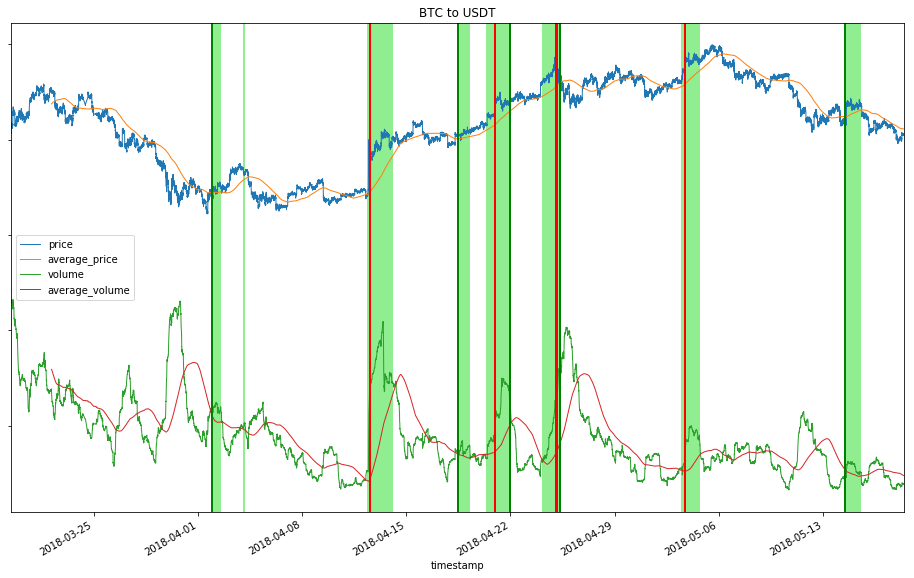

In [55]:
plot_results(include_all_buy=True, include_first_cross=False, include_orders=True)


Strategy: a simple signal set-based strategy
  description: trading according to signal set ['rsi_buy_2', 'rsi_sell_2', 'rsi_buy_3', 'rsi_sell_3']
Strategy settings:
  horizon = short
--

* Order execution log *

Start balance: cash = 1 USDT, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-04-02 05:53:49  	 OrderType.BUY    	 cash_balance ->         -1.00 USDT 	 currency_balance ->      0.000141 BTC 	 (1 BTC = 7050.00000000 USDT )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-04-02 05:53:49 rsi_value=0
2018-04-12 13:00:00  	 OrderType.SELL   	 cash_balance ->          1.09 USDT 	 currency_balance ->     -0.000141 BTC 	 (1 BTC = 7704.91226307 USDT )
   signal: rsi_sell_3 strength=3 trend=-1 horizon=0 timestamp=2018-04-12 13:00:00 rsi_value=84.3614320198976
2018-04-14 03:50:54  	 OrderType.BUY    	 cash_balance ->         -1.09 USDT 	 currency_balance ->      0.000136 BTC 	 (1 BTC = 7984.56819968 USDT )
   signal: rsi_buy_3 strength=3 trend=1 horizon=H

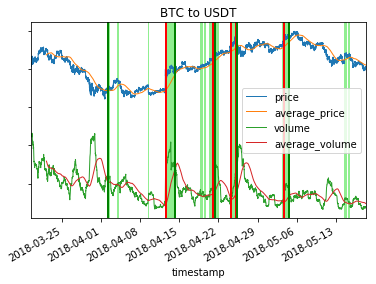

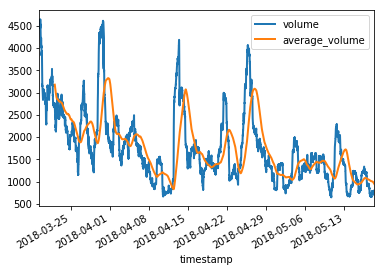

In [32]:
# Let's try another threshold
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(0.02,0.02)
orders, _ = strategy.get_orders(start_cash, start_crypto)

# Backtest the strategy
print(strategy.evaluate(start_cash, start_crypto, start_time, end_time))

# Plot trades
plot_results(True, False, True)

In [33]:
# Try out different thresholds for volume and price change
def calculate_profits(sell_strategy = None):
    volume_change_percents = []
    price_change_percents = []
    profits = []
    
    for percent_change_volume in np.arange(0, 0.10, 0.005):
        for percent_change_price in np.arange(0, 0.10, 0.005):
            strategy, all_buy_signals, first_cross_buy_signals = build_strategy(percent_change_volume,
                                                                                percent_change_price,
                                                                                buy_only_on_first_cross=True,
                                                                                sell_strategy=sell_strategy)
            orders, _ = strategy.get_orders(start_cash, start_crypto)
            evaluation = strategy.evaluate(start_cash, start_crypto, start_time, end_time, verbose=False)
            volume_change_percents.append(percent_change_volume)
            price_change_percents.append(percent_change_price)
            profits.append(evaluation.get_profit_percent())
    profit_df = pd.DataFrame.from_items(zip(["Volume change percent", "Price change percent", "Profit percent"], [volume_change_percents, price_change_percents, profits]))
    return profit_df

        

In [34]:
overbought_threshold = 95
oversold_threshold = 25
sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                  overbought_threshold, oversold_threshold, 
                                  transaction_currency, "RSI", source)
profit_df = calculate_profits(sell_strategy)

In [44]:
def plot_profit_df(profit_df, title=""):
    
    # Plot scatter
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.dist = 11
    
    x = profit_df["Volume change percent"]
    y = profit_df["Price change percent"]
    z = profit_df["Profit percent"]
    
    
    ax.scatter(x, y, z, c='r', marker='o')
    
    ax.set_xlabel('Volume change threshold')
    ax.set_ylabel('Price change threshold')
    ax.set_zlabel('Profit [%]')
    
    plt.title(title)
    plt.show()
    
    # Plot surface
    # Interpolated mesh
    
    #%matplotlib notebook
    #plt.interactive(True)
    
    fig3d = plt.figure(1)
    
    ax = fig3d.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(x, y)
    from scipy.interpolate import griddata
    from matplotlib import cm
    Z = griddata((x, y), z, (X, Y), method='cubic')
    
    surface_plot = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('Volume change threshold')
    ax.set_ylabel('Price change threshold')
    ax.set_zlabel('Profit [%]')
    ax.dist = 11
    
    plt.show()

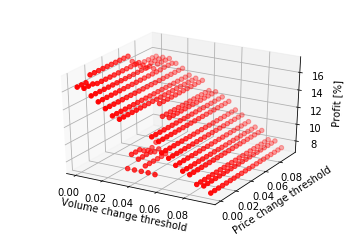

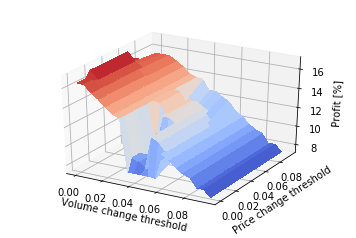

In [45]:
plot_profit_df(profit_df)

In [33]:
def write_to_excel(df, path):
    writer = pd.ExcelWriter(path)
    df.to_excel(writer,"Results")
    writer.save()

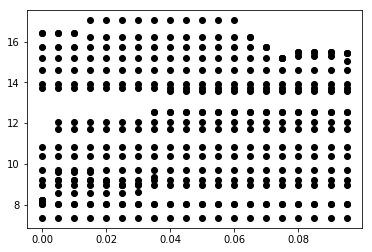

In [60]:
plt.plot(profit_df["Price change percent"], profit_df["Profit percent"], 'o', color='black');

In [62]:
# Find best performing parameters
sorted_by_profit = profit_df.sort_values("Profit percent", inplace=False, ascending=False)
sorted_by_profit

,Volume change percent,Price change percent,Profit percent
3,0.000,0.015,17.048724
4,0.000,0.020,17.048724
5,0.000,0.025,17.048724
6,0.000,0.030,17.048724
7,0.000,0.035,17.048724
8,0.000,0.040,17.048724
9,0.000,0.045,17.048724
10,0.000,0.050,17.048724
11,0.000,0.055,17.048724
12,0.000,0.060,17.048724


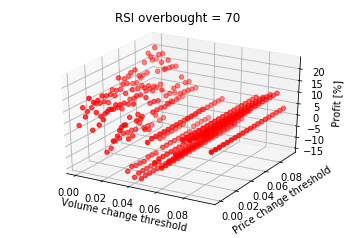

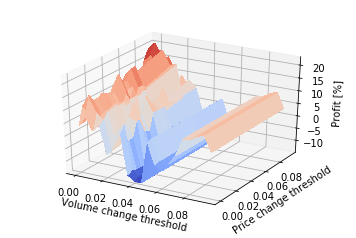

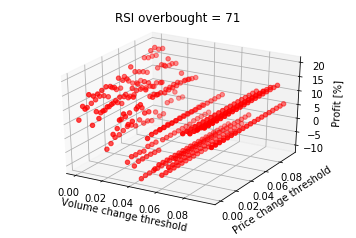

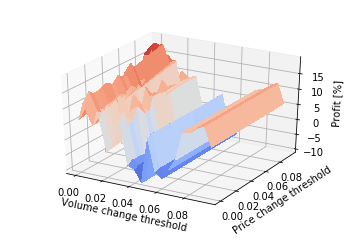

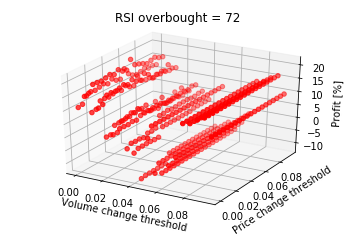

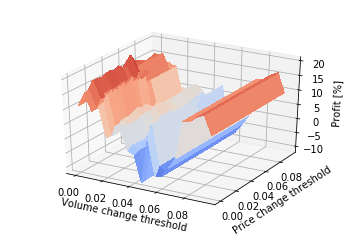

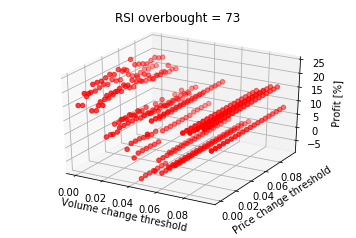

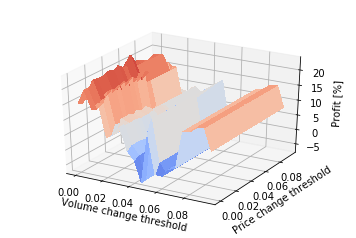

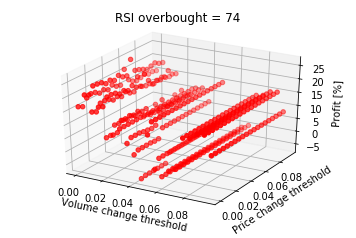

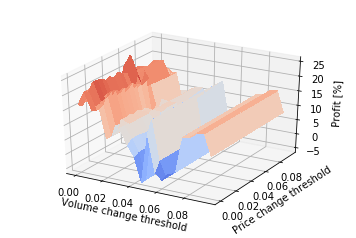

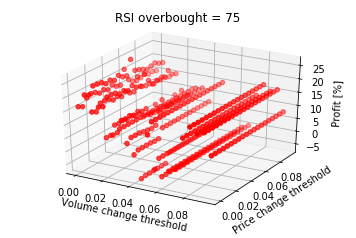

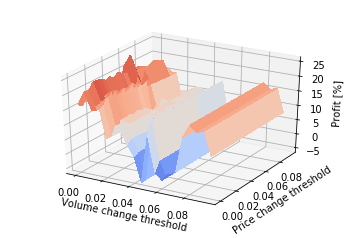

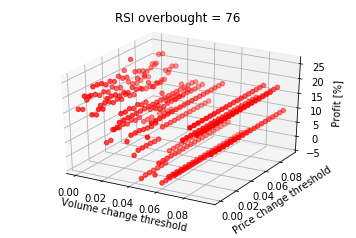

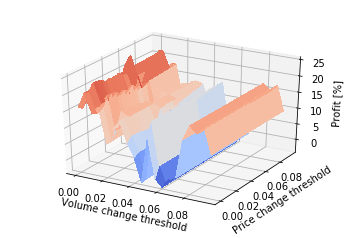

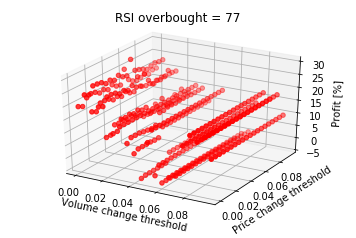

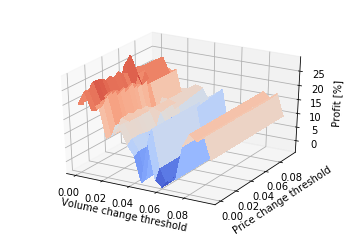

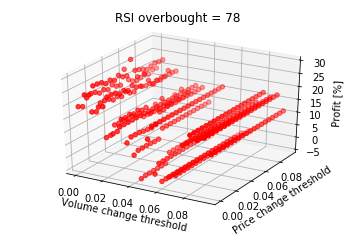

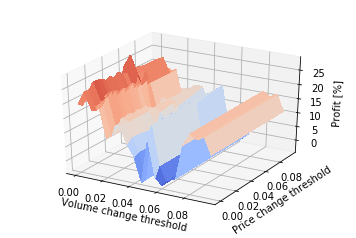

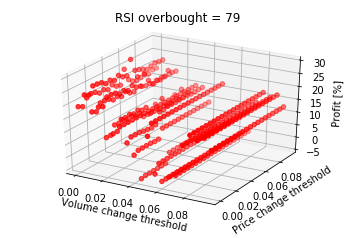

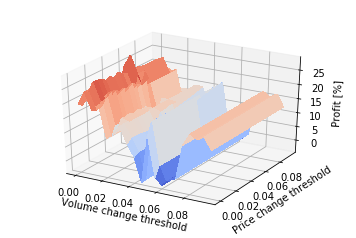

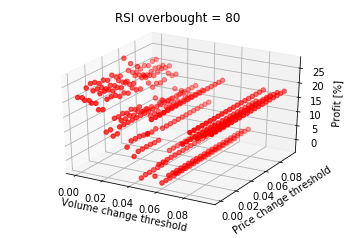

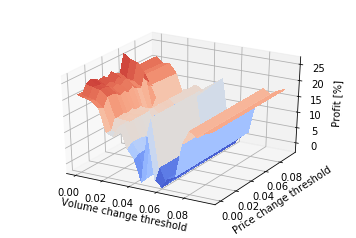

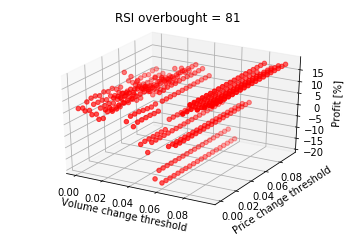

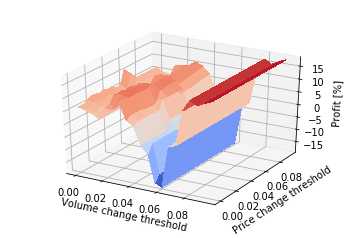

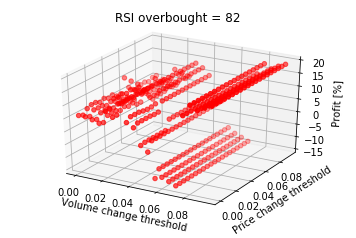

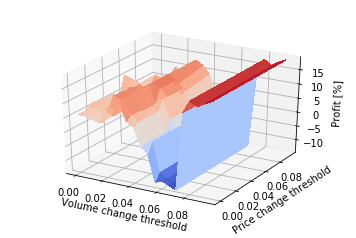

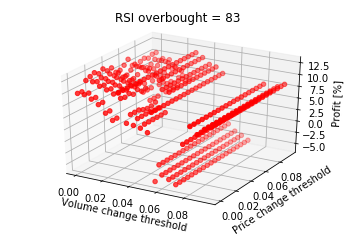

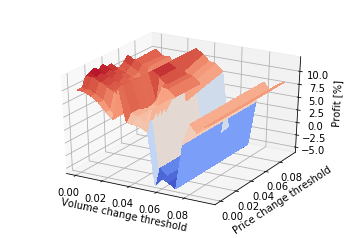

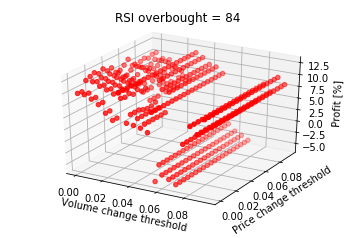

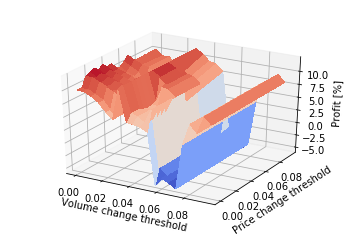

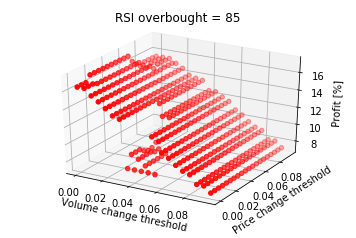

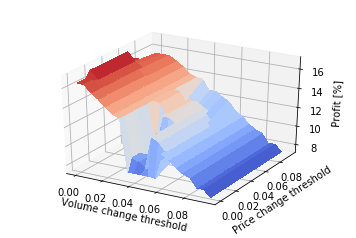

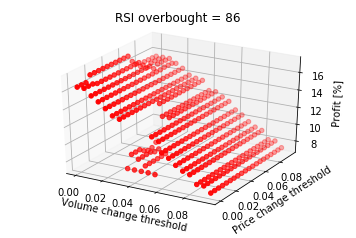

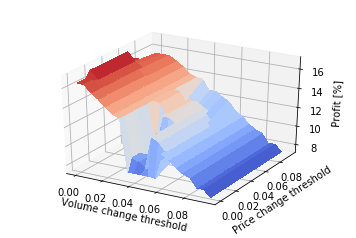

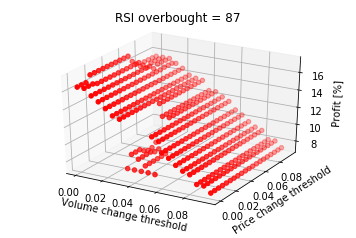

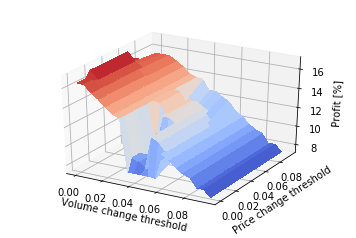

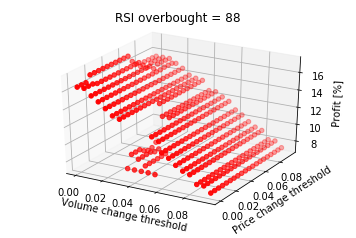

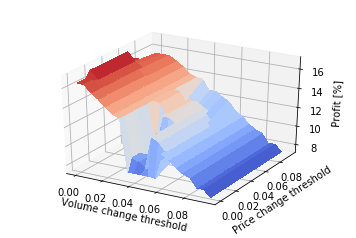

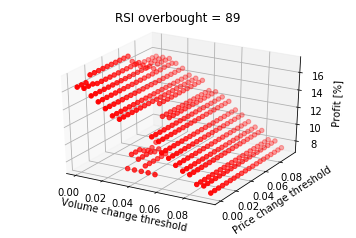

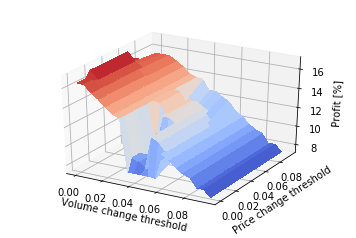

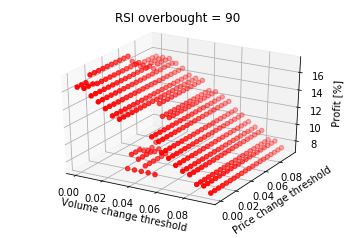

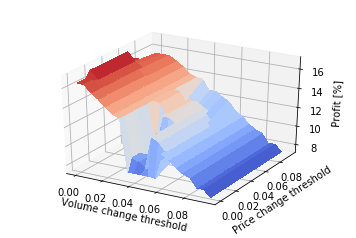

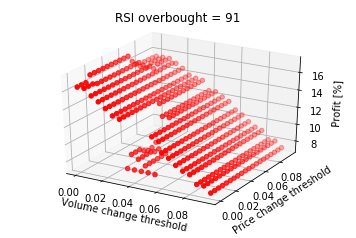

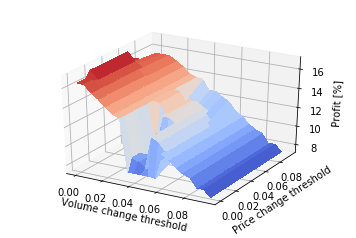

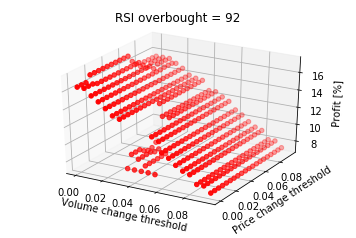

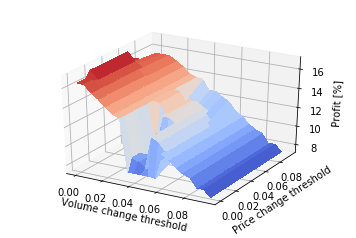

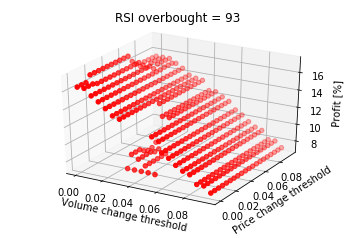

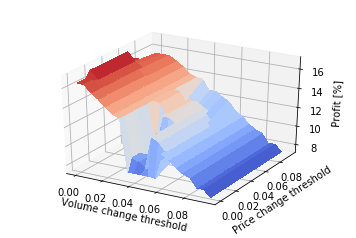

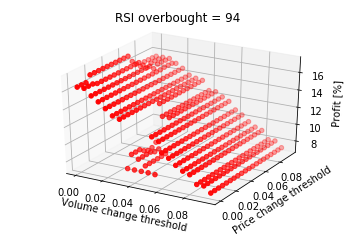

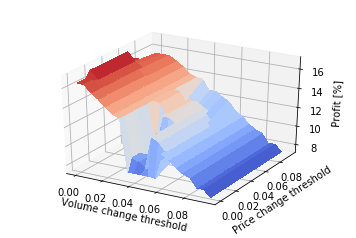

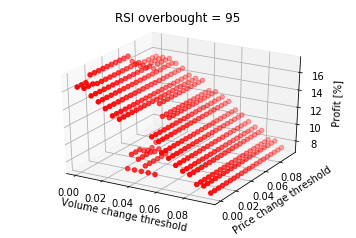

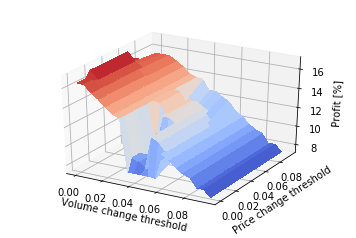

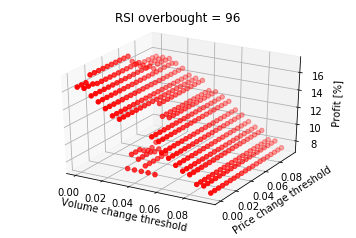

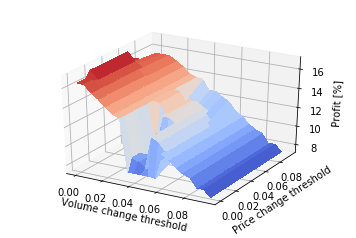

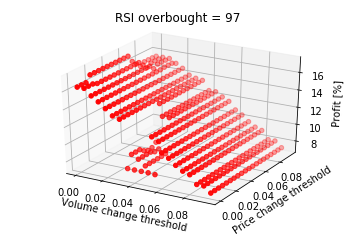

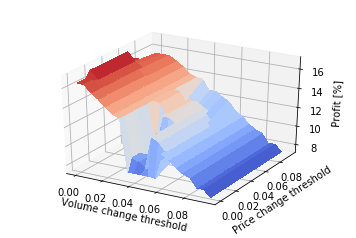

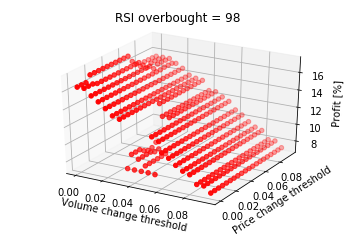

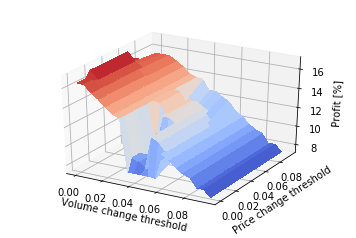

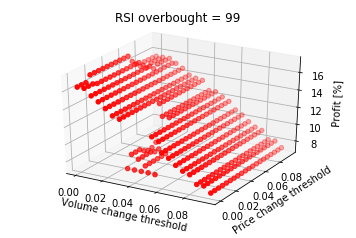

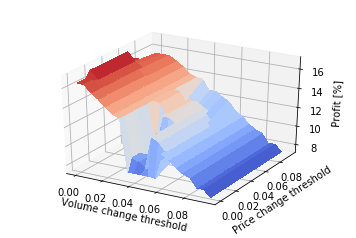

In [47]:
# Explore how RSI overbought influences the results
all_results = None
oversold_threshold = 20 # not used
for overbought_threshold in range(70,100):
    sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                      overbought_threshold, oversold_threshold, 
                                      transaction_currency, "RSI", source)
    profit_df = calculate_profits(sell_strategy)
    profit_df['RSI overbought'] = pd.Series([overbought_threshold] * len(profit_df), index=profit_df.index)
    if all_results is None:
        all_results = profit_df
    else:
        all_results = all_results.append(profit_df, ignore_index=True)
    plot_profit_df(profit_df, "RSI overbought = {}".format(overbought_threshold))

In [48]:
all_results


,Volume change percent,Price change percent,Profit percent,RSI overbought
0,0.000,0.000,3.721297,70
1,0.000,0.005,10.377301,70
2,0.000,0.010,7.795982,70
3,0.000,0.015,8.497943,70
4,0.000,0.020,9.419915,70
5,0.000,0.025,8.576555,70
6,0.000,0.030,8.308998,70
7,0.000,0.035,6.894668,70
8,0.000,0.040,11.574271,70
9,0.000,0.045,10.442857,70


In [49]:
sorted_by_profit = all_results.sort_values("Profit percent", inplace=False, ascending=False)
sorted_by_profit

,Volume change percent,Price change percent,Profit percent,RSI overbought
2831,0.005,0.055,29.291932,77
3231,0.005,0.055,28.891321,78
3631,0.005,0.055,28.891321,79
4011,0.000,0.055,26.717212,80
2822,0.005,0.010,26.422021,77
2823,0.005,0.015,26.317084,77
3222,0.005,0.010,26.030302,78
3622,0.005,0.010,26.030302,79
2824,0.005,0.020,26.000622,77
3223,0.005,0.015,25.925690,78


In [66]:
write_to_excel(all_results, "vbi_backtesting_btc_usdt.xlsx")

Strategy: a simple RSI-based strategy
  description: selling when rsi_value >= overbought_threshold, buying when rsi_value <= oversold threshold 
Strategy settings:
  overbought_threshold = 77.0
  oversold_threshold = 20
  horizon = short
--

* Order execution log *

Start balance: cash = 1000 USDT, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-04-01 22:42:39  	 OrderType.BUY    	 cash_balance ->      -1000.00 USDT 	 currency_balance ->      0.143511 BTC 	 (1 BTC = 6950.66486026 USDT )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-04-01 22:42:39 rsi_value=0
2018-04-12 13:00:00  	 OrderType.SELL   	 cash_balance ->       1102.98 USDT 	 currency_balance ->     -0.143511 BTC 	 (1 BTC = 7704.91226307 USDT )
   signal: rsi_sell_3 strength=3 trend=-1 horizon=0 timestamp=2018-04-12 13:00:00 rsi_value=84.3614320198976
2018-04-18 11:55:19  	 OrderType.BUY    	 cash_balance ->      -1102.98 USDT 	 currency_balance ->      0.135998 BTC 	 (1 BTC = 8090.0000000

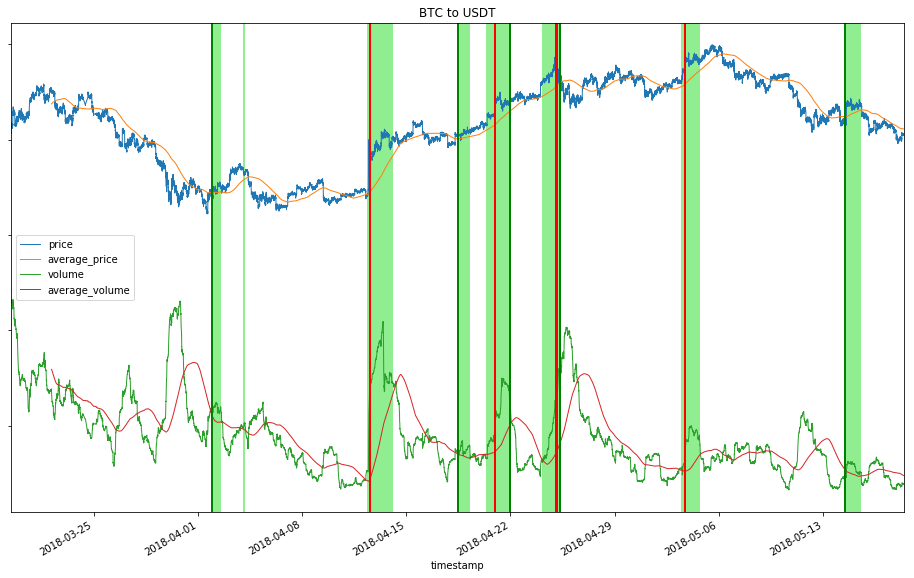

In [59]:
# Analyze the best parameter combination
overbought_threshold = sorted_by_profit.iloc[0]["RSI overbought"]
percent_change_volume = sorted_by_profit.iloc[0]["Volume change percent"]
percent_change_price = sorted_by_profit.iloc[0]["Price change percent"]

sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                      overbought_threshold, oversold_threshold, 
                                      transaction_currency, "RSI", source)
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(percent_change_volume,
                                                                                percent_change_price,
                                                                                buy_only_on_first_cross=True,
                                                                                sell_strategy=sell_strategy)
orders, _ = strategy.get_orders(start_cash, start_crypto)
evaluation = strategy.evaluate(1000, start_crypto, start_time, end_time, verbose=True)

plot_results()

In [57]:
# Let's establish the buy and hold and RSI baselines
from strategies import BuyAndHoldTimebasedStrategy
bah = BuyAndHoldTimebasedStrategy(start_time, end_time, transaction_currency, counter_currency, source)
bah.evaluate(start_cash, start_crypto, start_time, end_time)
rsi_strat = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                              75, 25, transaction_currency, "RSI", source)
rsi_strat.evaluate(start_cash, start_crypto, start_time, end_time)

--

* Order execution log *

Start balance: cash = 1 USDT, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-19 10:00:00  	 OrderType.BUY    	 cash_balance ->         -1.00 USDT 	 currency_balance ->      0.000122 BTC 	 (1 BTC = 8196.24900883 USDT )
2018-05-18 10:00:00  	 OrderType.SELL   	 cash_balance ->          0.98 USDT 	 currency_balance ->     -0.000122 BTC 	 (1 BTC = 8098.99000000 USDT )
End time: 2018-05-18 10:00:00

Summary
--
Number of trades: 2
End cash: 0.98 USDT
End crypto: 0.000000 BTC
Total value invested: 1 USDT
Total value after investment: 0.98 USDT (-1.68%)
Profit: -0.02 USDT


Strategy: a simple RSI-based strategy
  description: selling when rsi_value >= overbought_threshold, buying when rsi_value <= oversold threshold 
Strategy settings:
  overbought_threshold = 75
  oversold_threshold = 25
  horizon = short
--

* Order execution log *

Start balance: cash = 1 USDT, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-26 13:00:00  	 OrderType.BUY    	 cash_balance ->         -1.00 USDT 	 currency_balance ->      0.000123 BTC 	 (1 BTC = 8120.01000000 USDT )
   signal: rsi_buy_2 strength=2 trend=1 horizon=0 timestamp=2018-03-26 13:00:00 rsi_value=23.9619461483858
2018-04-12 13:00:00  	 OrderType.SELL   	 cash_balance ->          0.94 USDT 	 currency_balance ->     -0.000123 BTC 	 (1 BTC = 7704.91226307 USDT )
   signal: rsi_sell_3 strength=3 trend=-1 horizon=0 timestamp=2018-04-12 13:00:00 rsi_value=84.3614320198976
2018-05-11 04:00:00  	 OrderType.BUY    	 cash_balance ->         -0.94 USDT 	 currency_balance ->      0.000105 BTC 	 (1 BTC = 8948.0400000

Strategy: a simple RSI-based strategy
  description: selling when rsi_value >= overbought_threshold, buying when rsi_value <= oversold threshold 
Strategy settings:
  overbought_threshold = 97
  oversold_threshold = 20
  horizon = short
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-30 06:21:31  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     17.539766 ETH 	 (1 ETH = 0.05687077 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-03-30 06:21:31 rsi_value=0
End time: 2018-05-18 10:00:00

Summary
--
Number of trades: 1
End cash: 0.00 BTC
End crypto: 17.539766 ETH
Total value invested: 1 BTC
Total value after investment: 1.47 BTC (+47.11%)
Profit: 0.47 BTC
Total value invested: 8196.25 USDT (conversion on 2018-03-19 10:00:00)
Total value after investment: 11935.19 USDT (+45.62%) (conversion on 2018-05-18 10:00:00)
Profit: 3738.94 USDT


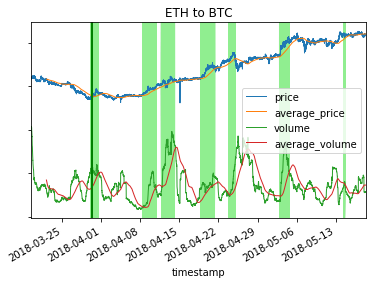

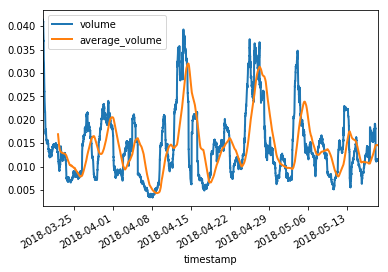

In [43]:
# Analyze the best parameter combination
overbought_threshold = 97#sorted_by_profit.iloc[0]["RSI overbought"]
percent_change_volume = sorted_by_profit.iloc[0]["Volume change percent"]/2
percent_change_price = sorted_by_profit.iloc[0]["Price change percent"]

sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                      overbought_threshold, oversold_threshold, 
                                      transaction_currency, "RSI", source)
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(percent_change_volume,
                                                                                percent_change_price,
                                                                                buy_only_on_first_cross=True,
                                                                                sell_strategy=sell_strategy)
orders, _ = strategy.get_orders(start_cash, start_crypto)
evaluation = strategy.evaluate(start_cash, start_crypto, start_time, end_time, verbose=True)

plot_results()